### Import the libraries 

In [1]:
import cv2
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import datetime
from glob import glob
import os
import exifread
import scipy.ndimage.interpolation
from pysolar.solar import *
import scipy.io as sio

import matplotlib as mpl
mpl.style.use('classic')
mpl.rc("figure", facecolor="white")

# User defined functions
from normalize_array import *
from readCoverage import *
from nearest import *

### MOD data

This imports the MOD data from MODIS satellite images. The various parameters viz., day number, hour, minute, average cloud mask value, and center cloud mask value are pre-computed using a MATLAB script *something.m*.

In [2]:
test = sio.loadmat('./cloud_mask/CloudMask_2015_MOD.mat', squeeze_me=True, struct_as_record=False)

data_array = test["DATA"]
print (data_array.shape)
day_number1 = data_array[:,0]
hour1 = data_array[:,1]
minute1 = data_array[:,2]
avg_cmask1 = data_array[:,3]
cen_cmask1 = data_array[:,4]

print ('The total number of MOD observations is', len(day_number1))

(268, 5)
The total number of MOD observations is 268


### MYD data

Just like MOD data, the MYD data are also extracted from the MODIS satellite images.

In [3]:
test = sio.loadmat('./cloud_mask/CloudMask_2015_MYD.mat', squeeze_me=True, struct_as_record=False)
    
data_array = test["DATA"]
print (data_array.shape)

day_number2 = data_array[:,0]
hour2 = data_array[:,1]
minute2 = data_array[:,2]
avg_cmask2 = data_array[:,3]
cen_cmask2 = data_array[:,4]

print ('The total number of MYD observations is', len(day_number2))

(265, 5)
The total number of MYD observations is 265


### Concatenating MOD & MYD data

We combine both MOD and MYD data into a single data series. This is because, we analyze all the observations together in a day-wise fashion.

In [4]:
day_series = np.concatenate([day_number1, day_number2])
hour_series = np.concatenate([hour1, hour2])
minute_series = np.concatenate([minute1, minute2])
avg_cmask_series = np.concatenate([avg_cmask1, avg_cmask2])
cen_cmask_series = np.concatenate([cen_cmask1, cen_cmask2])

### Converting MODIS observations into datetime objects

In [5]:
YEAR = 2015
datetime_MODIS_series = []
for i,item in enumerate(day_series):
    
    date_object = datetime.datetime(YEAR, 1, 1) + datetime.timedelta(item - 1)
    sw = datetime.datetime(date_object.year,date_object.month,date_object.day,int(hour_series[i]),int(minute_series[i]),0)
    datetime_MODIS_series.append(sw) 
    
print ('The total number of combined MODIS observations is',len(datetime_MODIS_series))

The total number of combined MODIS observations is 533


### Coverage value from ground-based sky cameras

The coverage ratio from ground-based sky-cameras are pre-computed using our cloud segmentation algorithm. The coverage results are archived in text files inside the folder `coverage_data`.

Please refer the refer the repository <a href="https://github.com/Soumyabrata/cloud-radiative-effect">cloud-radiative-effect</a> for the cloud coverage computation. 

The following section combines the results from all the individual-day results.

In [6]:
# Index all the files
global_files = []
start_dir = './coverage_data/'

# Check for all text files.
pattern  = "*.txt"
for direc,_,_ in os.walk(start_dir):
    global_files.extend(glob(os.path.join(direc,pattern)))


datetime_series = []
COV_series = []
for one_file in global_files:
    
    (datetime_COV,COV_values) = readingCOVERAGE(one_file)  
    datetime_series = np.concatenate([datetime_series, datetime_COV])
    COV_series = np.concatenate([COV_series, COV_values])

### Combine data from cloud mask and cloud coverage 

In [7]:
if os.path.isfile('./cmask_coverage_result/2015data.txt'):
    print ('Computed file exists')
else:
    print ('Calculating for the first time')
    
    file_name = './cmask_coverage_result/2015data.txt'
    text_file = open(file_name, "w")

    # Header line
    text_file.write("date,timeMODIS,timeImage,cloudMaskForMODISTime,coverageForMODISTime\n")    

    # Parsing the datetime objects of MODIS
    for robin,particular_date in enumerate(datetime_MODIS_series):

        # Check time is from MODIS, and it checks sky camera image timestamps
        check_time = particular_date
        (time_found,diff_ts) = nearest(check_time,datetime_series) 

        if abs(diff_ts)<900: #15 mins
            #print ('check time=',check_time,' and found time=',time_found)
            #print ('within 15 mins---adding')
            location_index = np.where( datetime_series == time_found)
            coverage_item = COV_series[location_index]
            cmask_item = avg_cmask_series[robin]
            text_file.write("%s,%s,%s,%s,%s\n" %(particular_date, check_time, time_found, cmask_item, coverage_item[0])) 

    text_file.close() 
    print ('Computation complete')    

Calculating for the first time
Computation complete


### Data points of *combined* cloud mask and cloud coverage values

In [8]:
file_path = "./cmask_coverage_result/2015data.txt"
input_file = csv.DictReader(open(file_path))


final_cmask = []
final_coverage = []

for row in input_file:
    
    c_mask = float(row["cloudMaskForMODISTime"])
    coverage_image = float(row["coverageForMODISTime"])
    
    final_cmask.append(c_mask)
    final_coverage.append(coverage_image)
    
    
final_cmask = np.array(final_cmask)
final_coverage = np.array(final_coverage)

### Results 

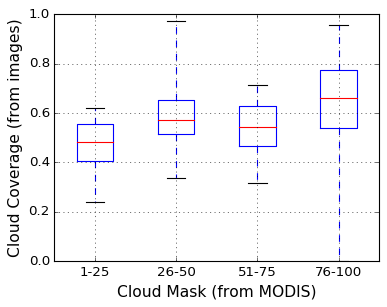

In [9]:
NO_OF_BINS = 4   
box_mask = [[] for _ in range(NO_OF_BINS)]
mask100 = np.multiply(final_cmask,100)
  
for i,item in enumerate(mask100):
    whichBin = int(item/(100/NO_OF_BINS))
    if whichBin==NO_OF_BINS:
        whichBin = NO_OF_BINS - 1
    
    box_mask[whichBin].append(final_coverage[i])
    
    
labelList = []
for ll in np.arange(1,1+NO_OF_BINS):
    labelList.append(str(int((100/NO_OF_BINS)*(ll-1)+1)) + '-' + str(int((100/NO_OF_BINS)*ll)))   
    

fig = plt.figure(2,figsize=(5, 4))
ax = fig.add_subplot(111)
plt.boxplot(box_mask,whis=5)
ax.set_xticklabels(labelList)
ax.set_ylabel('Cloud Coverage (from images)', fontsize=14)
ax.set_xlabel('Cloud Mask (from MODIS)', fontsize=14)
ax.grid(True)
plt.tight_layout()
plt.savefig('./figs/result.pdf', format='pdf')
plt.show()